# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/> 
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU 
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.
 
<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/> 
  
</tr></table>

In [212]:
import numpy as np
import matplotlib.pyplot as plt

def plot_one_image(image: np.ndarray, text=None) -> None:
    """
    Отобразить изображение с помощью matplotlib.
    Вспомогательная функция.
    
    :param image: изображение для отображения
    :return: None
    """
    fig, axs = plt.subplots(1, 1, figsize=(8, 7))
    axs.imshow(image)
    axs.axis('off')
    if text:
        axs.text(
            x=image.shape[1] // 2,  # Положение по ширине (по центру)
            y=20,  # Высота надписи
            s=text,  # Сам текст
            fontsize=20,  # Размер шрифта
            color="white",  # Цвет текста
            ha="center",  # Выравнивание по центру
            bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')  # Фон текста
        )
    plt.plot()

In [213]:
import cv2

def extract_and_normalize_tail(image_path, mask_path):
    """
    Извлекает область хвоста из изображения и маски, нормализует её и возвращает обработанные изображения.
    
    Параметры:
        image_path (str): Путь к исходному изображению.
        mask_path (str): Путь к маске изображения.
    
    Возвращает:
        tuple: Кортеж из четырех элементов:
            - Исходная область хвоста.
            - Исходная маска хвоста.
            - Нормализованное изображение хвоста.
            - Нормализованная маска хвоста.
    """
    
    # Загрузка изображения и маски
    original_image = cv2.imread(image_path)
    mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Поиск контуров в маске и выделение наибольшего (предполагаем, что это хвост)
    contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, width, height = cv2.boundingRect(largest_contour)
    
    # Вырезание области хвоста из изображения и маски
    tail_region = original_image[y:y+height, x:x+width]
    tail_mask_region = mask_image[y:y+height, x:x+width]
    
    # Поиск контуров в вырезанной маске для нормализации
    tail_contours, _ = cv2.findContours(tail_mask_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_tail_contour = max(tail_contours, key=cv2.contourArea)
    
    # Вычисление параметров эллипса для нормализации
    angle = cv2.fitEllipse(largest_tail_contour)[2]
    
    # Поворот изображения и маски на угол эллипса
    rows, cols = tail_region.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_tail = cv2.warpAffine(tail_region, rotation_matrix, (cols, rows))
    rotated_mask = cv2.warpAffine(tail_mask_region, rotation_matrix, (cols, rows))
    
    # Обрезка повернутого изображения по границам контура
    rotated_contours, _ = cv2.findContours(rotated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_rotated_contour = max(rotated_contours, key=cv2.contourArea)
    x, y, width, height = cv2.boundingRect(largest_rotated_contour)
    cropped_tail = rotated_tail[y:y+height, x:x+width]
    cropped_mask = rotated_mask[y:y+height, x:x+width]
    
    # Приведение размеров к стандартному формату 128x128
    normalized_tail = cv2.resize(cropped_tail, (128, 128))
    normalized_mask = cv2.resize(cropped_mask, (128, 128))
    
    return tail_region, tail_mask_region, normalized_tail, normalized_mask

In [214]:
def calculate_iou(mask1, mask2):
    """
    Вычисляет метрику Intersection over Union (IoU) для двух масок.
    
    Параметры:
        mask1 (numpy.ndarray): Первая бинарная маска.
        mask2 (numpy.ndarray): Вторая бинарная маска.
    
    Возвращает:
        float: Значение IoU.
    """
    intersection = cv2.bitwise_and(mask1, mask2)
    union = cv2.bitwise_or(mask1, mask2)
    iou_value = np.sum(intersection) / np.sum(union)
    return iou_value


def process_photos(image_path, mask_path):
    """
    Обрабатывает изображение и маску, визуализирует результаты и вычисляет IoU.
    
    Параметры:
        image_path (str): Путь к исходному изображению.
        mask_path (str): Путь к маске изображения.
    
    Возвращает:
        float: Значение IoU между исходной и нормализованной маской.
    """
    # Извлечение и нормализация хвоста
    tail, tail_mask, normalized_tail, normalized_mask = extract_and_normalize_tail(image_path, mask_path)
    
    # Создание фигуры для визуализации
    fig, axes = plt.subplots(5, 1, figsize=(6, 6))
  
    axes[0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    axes[0].set_title("Исходное изображение")
    axes[0].axis('off')
    
    axes[1].imshow(tail_mask, cmap='gray')
    axes[1].set_title("Маска")
    axes[1].axis('off')
    
    axes[2].imshow(cv2.cvtColor(tail, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Хвост по маске")
    axes[2].axis('off')
    
    axes[3].imshow(cv2.cvtColor(normalized_tail, cv2.COLOR_BGR2RGB))
    axes[3].set_title("Обработанный хвост")
    axes[3].axis('off')

    axes[4].imshow(cv2.cvtColor(normalized_mask, cv2.COLOR_BGR2RGB))
    axes[4].set_title("Обработанная маска")
    axes[4].axis('off')
    
    # Вычисление IoU
    resized_tail_mask = cv2.resize(tail_mask, (128, 128))
    iou_value = calculate_iou(resized_tail_mask, normalized_mask)

    fig.text(1, 0.02, f"IoU: {iou_value:.4f}", fontsize=16, ha='center', color='blue')

    # Отображение фигуры
    plt.tight_layout()
    plt.show()

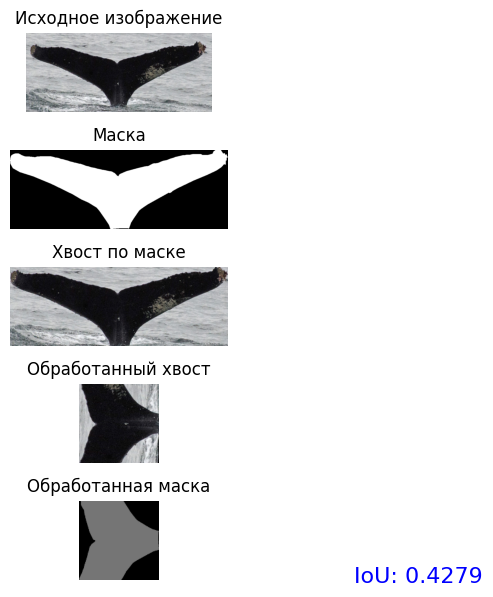

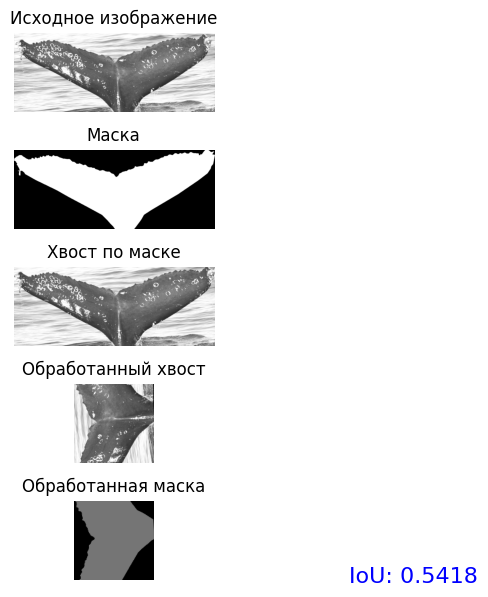

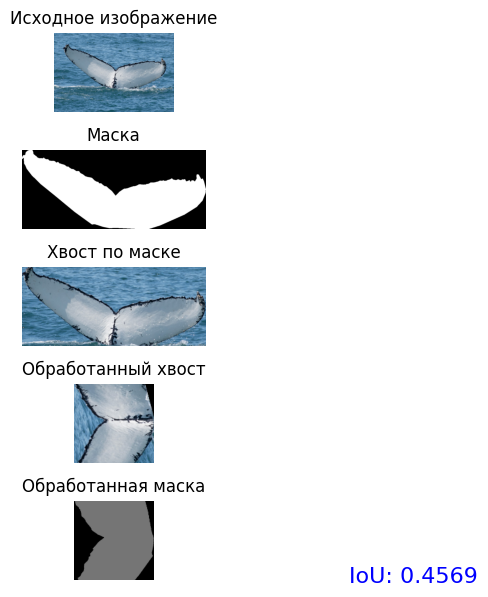

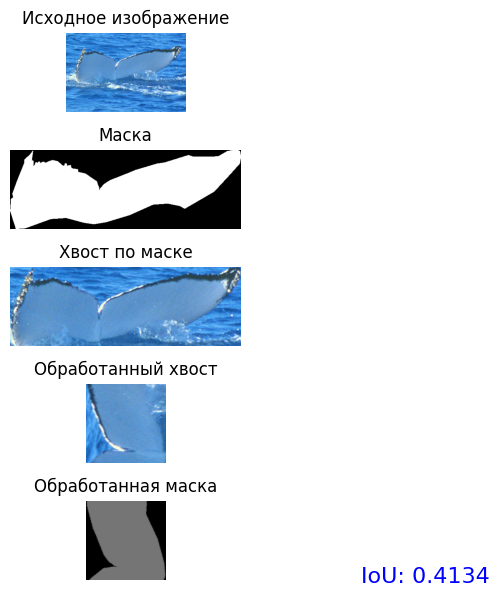

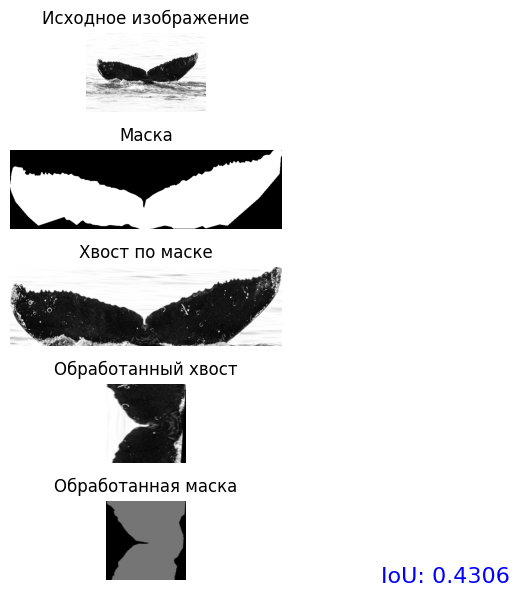

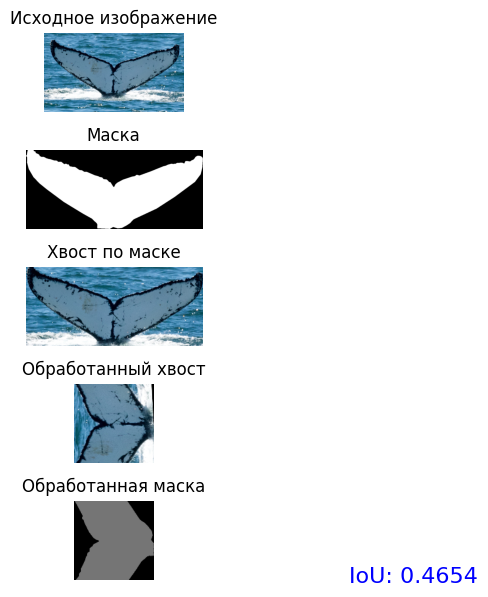

In [215]:
from os import listdir
from os.path import isfile, join

dataset_path = 'whale_tail/images'
mask_path = 'whale_tail/ground_truth'

images_path = [join(dataset_path,f) for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
masks_path = [join(mask_path,f) for f in listdir(mask_path) if f[-3:] == 'png']

for img_path, mask_path in zip(images_path, masks_path):
    process_photos(img_path, mask_path)

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

In [216]:
from skimage.feature import hog

def prepare_image(img):
    """
    Подготавливает изображение: преобразует в оттенки серого (если необходимо) и применяет гистограммную эквализацию и размытие.
    
    Параметры:
        img (numpy.ndarray): Входное изображение.
    
    Возвращает:
        numpy.ndarray: Обработанное изображение.
    """
    # Преобразование в оттенки серого, если изображение цветное
    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    
    # Применение гистограммной эквализации
    equalized_img = cv2.equalizeHist(gray_img)
    
    # Применение размытия по Гауссу
    blurred_img = cv2.GaussianBlur(equalized_img, (5, 5), 0)
    
    return blurred_img

In [217]:
def calculate_hog_features(img, cell_size=(8, 8), block_size=(2, 2), num_bins=9):
    """
    Вычисляет HOG-признаки для изображения.
    
    Параметры:
        img (numpy.ndarray): Входное изображение.
        cell_size (tuple): Размер ячейки в пикселях.
        block_size (tuple): Размер блока в ячейках.
        num_bins (int): Количество ориентационных бинов.
    
    Возвращает:
        tuple: HOG-признаки и визуализация HOG.
    """
    # Вычисление HOG-признаков
    features, _ = hog(
        img, orientations=num_bins, pixels_per_cell=cell_size,
        cells_per_block=block_size, visualize=True
    )
    
    return features

In [218]:
def locate_eye(img, eye_template, template_hog_features, template_size):
    """
    Находит глаз на изображении с использованием корреляции и HOG-признаков.
    
    Параметры:
        img (numpy.ndarray): Входное изображение.
        eye_template (numpy.ndarray): Шаблон глаза.
        template_hog_features (numpy.ndarray): HOG-признаки шаблона.
        template_size (tuple): Размер шаблона.
    
    Возвращает:
        tuple: Координаты глаза, значение корреляции и оценка HOG.
    """
    # Предварительная обработка изображения
    processed_img = prepare_image(img)
    
    # Поиск шаблона с использованием корреляции
    correlation_result = cv2.matchTemplate(processed_img, eye_template, cv2.TM_CCOEFF_NORMED)
    _, max_corr, _, max_pos = cv2.minMaxLoc(correlation_result)
    
    # Вырезание области вокруг найденной позиции
    x, y = max_pos
    window = processed_img[y:y + template_size[0], x:x + template_size[1]]
    
    # Проверка размера окна и вычисление HOG-оценки
    if window.shape == template_size:
        window_hog = calculate_hog_features(window)
        hog_score = np.sum(window_hog - template_hog_features)
    else:
        hog_score = -1
    
    return max_pos, max_corr, hog_score

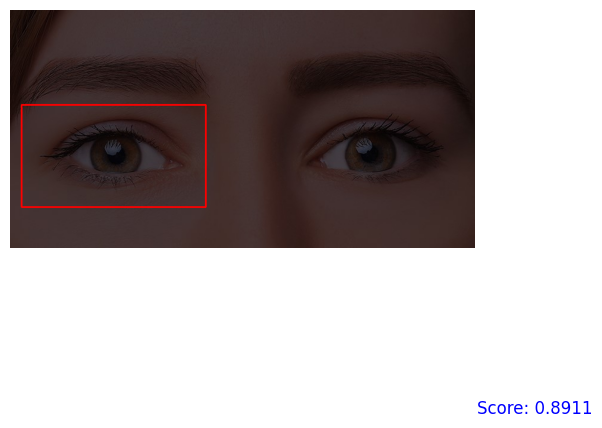

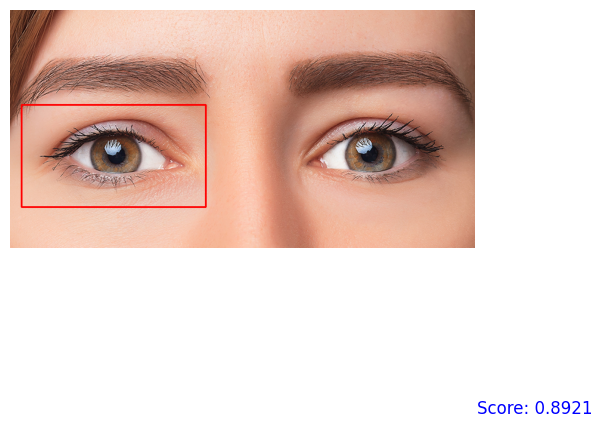

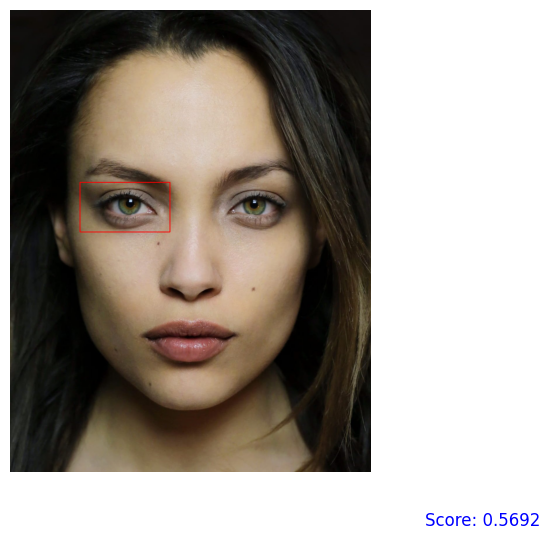

In [219]:
# Список путей к изображениям
image_paths = ["hog/eyes_dark.jpg", "hog/eyes.jpg", "hog/woman.jpg"]

# Загрузка шаблона глаза
template_path = "hog/eye.png"
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
template_size = template.shape

# Вычисление HOG-признаков для шаблона
template_hog = calculate_hog_features(template)

# Обработка каждого изображения
for path in image_paths:
    img = cv2.imread(path)
    
    # Поиск глаза на изображении
    eye_position, correlation_score, hog_score = locate_eye(img, template, template_hog, template_size)
    
    # Рисование прямоугольника вокруг найденного глаза
    if eye_position:
        x, y = eye_position
        h, w = template_size
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    fig = plt.figure(figsize=(6, 6))
    # Отображение результата
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    fig.text(1, 0.02, f"Score: {correlation_score:.4f}", fontsize=12, ha='center', color='blue')
    plt.show()